## **Preface**



⏩ This is second part of ipynb file from my Face Recognition Project using VGG. Please see the first part of ipynb file which is "project_1_EDA.ipynb". The purpose of this Project are compare VGG16 & VGG19 model architecture to identify male/female from the image files.<br>
▶ Image files are stored in folder "Dataset/train/" and "Dataset/test/" which are cleaned using "project_1_EDA.ipynb".<br>
▶ Label files are stored in "Dataset/list_train_clean.csv"  and "Dataset/list_test_clean.csv"

In [ ]:
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
from sklearn.model_selection import train_test_split
import shutil


⏩ If you want use gdrive, mount it first

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd 'gdrive/MyDrive/Colab Notebooks/Face Recognition/'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/Colab Notebooks/Face Recognition


⏩ As of now, i used local computer with nvidia gpu Geforce GTX 1660 Super

In [ ]:
%pwd

'C:\\Users\\rumah\\Project\\Face Recognition'

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D , Flatten, GlobalAveragePooling2D
from tensorflow.keras.applications import InceptionV3
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

⏩ Let's create constant var

In [ ]:
TRAIN_PATH = 'Dataset/train/'
TEST_PATH = 'Dataset/test/'
IMG_SIZE = (218, 178)
BATCH_SIZE = 32
EPOCH_SIZE = 20


⏩ Loading the label files

In [ ]:
df_train = pd.read_csv('Dataset/list_train_clean.csv')
df_test = pd.read_csv('Dataset/list_test_clean.csv')

#df_train

⏩ Convert datatype of label from object to string. ImageDataGenerator want the datatype to be string

In [ ]:
df_train['Male'] = df_train['Male'].astype("string")
df_test['Male'] = df_test['Male'].astype("string")
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filenames  4000 non-null   object
 1   Male       4000 non-null   string
dtypes: object(1), string(1)
memory usage: 62.6+ KB


⏩ Rename the label from 1/0 to Male/Female

In [ ]:
df_train.loc[df_train['Male'] == '1', ['Male']] = 'Male'
df_train.loc[df_train['Male'] == '0', ['Male']] = 'Female'
df_train

,Filenames,Male
0,098446.jpg,Female
1,189077.jpg,Female
2,140986.jpg,Female
3,038818.jpg,Male
4,104595.jpg,Male
...,...,...
3995,093110.jpg,Female
3996,198880.jpg,Male
3997,013392.jpg,Male
3998,098793.jpg,Female


⏩ Check proportional between Male and Female

In [ ]:
df_train['Male'].value_counts(normalize=True)*100

Male
Female    59.225
Male      40.775
Name: proportion, dtype: Float64

In [ ]:
df_test['Male'].value_counts(normalize=True)*100

Male
Female    58.4
Male      41.6
Name: proportion, dtype: Float64

⏩ Random check whether the label is correct or not

C:\Users\rumah\AppData\Local\Temp\ipykernel_15716\2761382631.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = row[0]


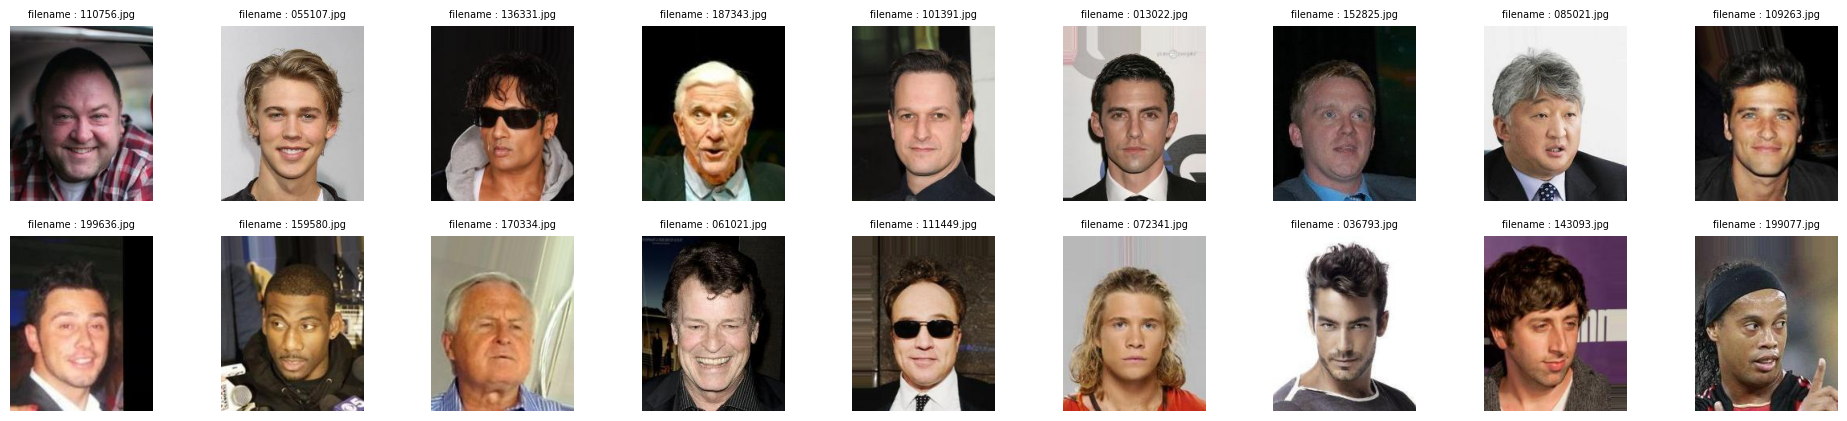

In [ ]:
## Sampling random check for male images
x=0
fig = plt.figure(figsize = (24,5))
#for idx, row in df_train[['Filenames']].sample(n=18).iterrows() :
for idx, row in df_train.loc[df_train['Male'] == 'Male', ['Filenames']].sample(n=18).iterrows() :
  f = row[0]
  img_path = f'Dataset/train/{f}'
  #print(img_path)
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
  img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
  fig.add_subplot(2,9,x+1)
  plt.title(f'filename : {f}', fontsize = 7)
  plt.axis('off')
  plt.imshow(img)
  x += 1

In [ ]:
df_test.loc[df_test['Male'] == '1', ['Male']] = 'Male'
df_test.loc[df_test['Male'] == '0', ['Male']] = 'Female'
df_test

,Filenames,Male
0,122315.jpg,Male
1,153759.jpg,Male
2,115290.jpg,Male
3,157437.jpg,Female
4,192358.jpg,Female
...,...,...
995,144965.jpg,Female
996,026421.jpg,Male
997,151442.jpg,Female
998,012915.jpg,Female


C:\Users\rumah\AppData\Local\Temp\ipykernel_15716\3803919608.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  f = row[0]


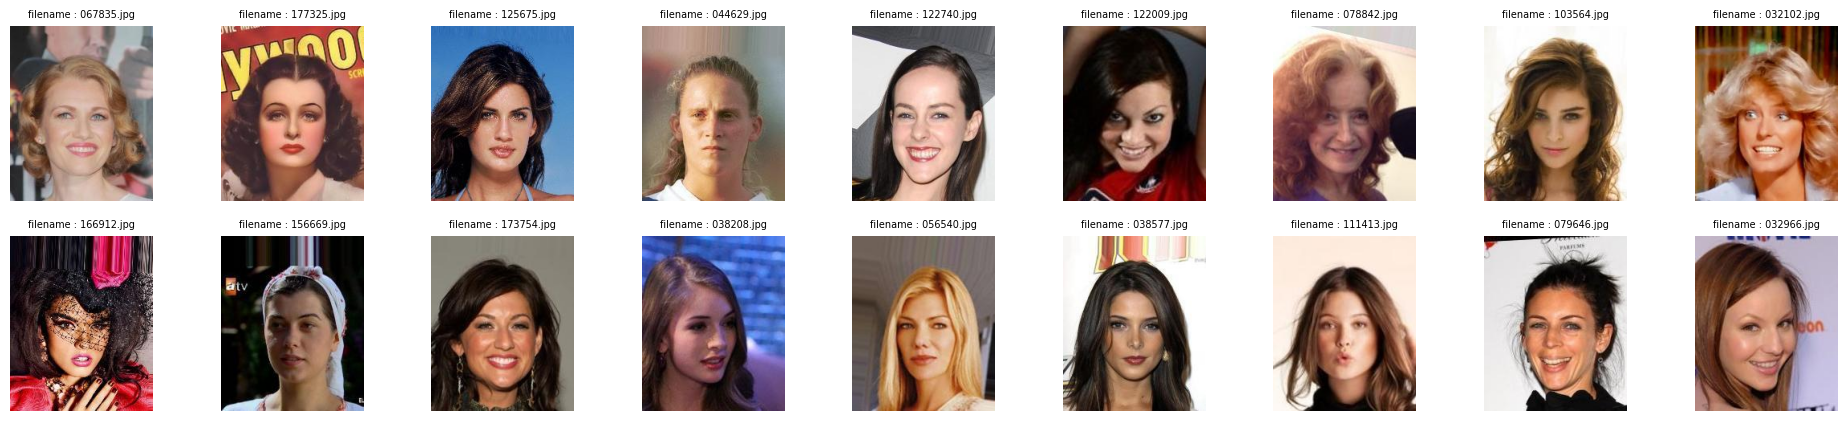

In [ ]:
## Sampling random check for Female images
x=0
fig = plt.figure(figsize = (24,5))
#for idx, row in df_train[['Filenames']].sample(n=18).iterrows() :
for idx, row in df_test.loc[df_test['Male'] == 'Female', ['Filenames']].sample(n=18).iterrows() :
  f = row[0]
  img_path = f'Dataset/test/{f}'
  #print(img_path)
  img = cv2.imread(img_path, cv2.IMREAD_UNCHANGED)
  img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGBA)
  fig.add_subplot(2,9,x+1)
  plt.title(f'filename : {f}', fontsize = 7)
  plt.axis('off')
  plt.imshow(img)
  x += 1

⏩ We use data augmentation to rich the variation of images. <br>
Data Augmentation is the process of expanding the image training data, by using transformations such as random rotations, shear transforms, shifts zooms and flips, on available image data.

In [ ]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    df_train,
    TRAIN_PATH,
    x_col='Filenames',
    y_col='Male',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 4000 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    df_test,
    TEST_PATH,
    x_col='Filenames',
    y_col='Male',
    target_size=IMG_SIZE,
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 1000 validated image filenames belonging to 2 classes.


## **Training with VGG19 pre-Trained Model**

⏩ Load the pre trained model VGG19 from keras using "imagenet" weight.

In [ ]:
base_model = tf.keras.applications.vgg19.VGG19(weights='imagenet', include_top=False, input_shape= IMG_SIZE + (3,))

⏩ Let's freeze the pre trained model as we want prevent the weights of that layer from being updated during training

In [ ]:
base_model.trainable = False
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

⏩ Let's add the custom layer on top of base model

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(256,activation='relu'))
model.add(Dense(64,activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(2, activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 6, 5, 512)         20024384  
                                                                 
 flatten (Flatten)           (None, 15360)             0         
                                                                 
 dense (Dense)               (None, 256)               3932416   
                                                                 
 dense_1 (Dense)             (None, 256)               65792     
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 32)                1

⏩ Compile it using adam optimizer

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

⏩ Let's define the Checkpoint and other callback function

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.001)
# Define a ModelCheckpoint callback to save the model weights during training
checkpoint_callback = ModelCheckpoint(filepath='Dataset/vgg_weights.h5',
                                      save_best_only=True,
                                      save_weights_only=False)

callbacks = [checkpoint_callback, earlystop, learning_rate_reduction]


⏩ Time to train the model with epoch 20. Please pray and sleep early as this process take hours, maybe days 😏 <br>
PS:I left this process without check the progress, as i have to go to my hometown for 3 days 😀

In [ ]:
%%time
history = model.fit(train_generator,
                    validation_data = test_generator,
                    validation_steps=len(df_test)//BATCH_SIZE,
                    steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=EPOCH_SIZE,
                    verbose = 1,
                    callbacks=callbacks
                    )

Epoch 1/20
125/125 [==============================] - ETA: 0s - loss: 0.4125 - accuracy: 0.8138 WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: loss,accuracy,val_loss,val_accuracy,lr


C:\Project\Anaconda3\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


125/125 [==============================] - 1842s 15s/step - loss: 0.4125 - accuracy: 0.8138 - val_loss: 0.2633 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - 1907s 15s/step - loss: 0.3065 - accuracy: 0.8650 - val_loss: 0.2384 - val_accuracy: 0.9103 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - 1898s 15s/step - loss: 0.2627 - accuracy: 0.8915 - val_loss: 0.2109 - val_accuracy: 0.9173 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - 1916s 15s/step - loss: 0.2454 - accuracy: 0.9020 - val_loss: 0.1990 - val_accuracy: 0.9163 - lr: 0.0010
Epoch 5/20
125/125 [==============================] - 1906s 15s/step - loss: 0.2366 - accuracy: 0.8997 - val_loss: 0.2144 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 6/20
125/125 [==============================] - 1918s 15s/step - loss: 0.2429 - accuracy: 0.8945 - val_loss: 0.2292 - val_accuracy: 0.9123 - lr: 0.0010
Epoch 7/20
125/125 [==============================] - 1917s 15s

⏩ Save the history and model after finishing train.

In [ ]:
np.save('training_history.npy', history.history)
model.save("model_finish.h5")

In [ ]:
history_vgg19_ep20 = history

In [ ]:
print(f"accuracy : {history_vgg19_ep20.history['accuracy'] [-1]}")
print(f"validation accuracy : {history_vgg19_ep20.history['val_accuracy'] [-1]}")

accuracy : 0.9200000166893005
validation accuracy : 0.8850806355476379


⏩ Let's continue train again with additional 10 epoch

In [ ]:
%%time
history2 = model.fit(train_generator,
                    validation_data = test_generator,
                    validation_steps=len(df_test)//BATCH_SIZE,
                    steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=10,
                    verbose = 1,
                    callbacks=callbacks
                    )

Epoch 1/10
125/125 [==============================] - 1878s 15s/step - loss: 0.1707 - accuracy: 0.9300 - val_loss: 0.1964 - val_accuracy: 0.9214 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 1879s 15s/step - loss: 0.1640 - accuracy: 0.9333 - val_loss: 0.2216 - val_accuracy: 0.9183 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 1877s 15s/step - loss: 0.1638 - accuracy: 0.9327 - val_loss: 0.1869 - val_accuracy: 0.9254 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 1874s 15s/step - loss: 0.1494 - accuracy: 0.9395 - val_loss: 0.2069 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 1874s 15s/step - loss: 0.1611 - accuracy: 0.9312 - val_loss: 0.2034 - val_accuracy: 0.9224 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - 1878s 15s/step - loss: 0.1609 - accuracy: 0.9342 - val_loss: 0.2802 - val_accuracy: 0.9062 - lr: 0.0010
Epoch 7/10
125/125 [==============================] 

⏩ Save the history and model

In [ ]:
np.save('training_history2.npy', history.history)
model.save("model_finish2.h5")

In [ ]:
np.save('training_history2_vgg19_ep30.npy', history2.history)
history_vgg19_ep30 = history2

## **Training with VGG16 pre-Trained Model**

⏩ Load the pre trained model VGG19 from keras using "imagenet" weight.

In [ ]:
base_model16 = tf.keras.applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape= IMG_SIZE + (3,))

58889256/58889256 [==============================] - 4s 0us/step


⏩ Freeze the base model

In [ ]:
base_model16.trainable = False
base_model16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 218, 178, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 218, 178, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 218, 178, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 109, 89, 64)       0         
                                                                 
 block2_conv1 (Conv2D)       (None, 109, 89, 128)      73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 109, 89, 128)      147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 44, 128)       0     

⏩ Add custom model on top of base model

In [ ]:
model2 = Sequential()
model2.add(base_model16)
model2.add(Flatten())
model2.add(Dense(256,activation='relu'))
model2.add(Dense(256,activation='relu'))
model2.add(Dense(64,activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(32, activation='relu'))
model2.add(Dense(2, activation='sigmoid'))
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 5, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 15360)             0         
                                                                 
 dense_6 (Dense)             (None, 256)               3932416   
                                                                 
 dense_7 (Dense)             (None, 256)               65792     
                                                                 
 dense_8 (Dense)             (None, 64)                16448     
                                                                 
 dense_9 (Dense)             (None, 32)                2080      
                                                                 
 dense_10 (Dense)            (None, 32)               

In [ ]:
model2.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy',
                                            patience=4,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.001)
# Define a ModelCheckpoint callback to save the model weights during training
checkpoint_callback = ModelCheckpoint(filepath='Dataset/vgg_weights16.h5',
                                      save_best_only=True,
                                      save_weights_only=False)

In [ ]:
callbacks = [checkpoint_callback, earlystop, learning_rate_reduction]

⏩ Time to train the model with epoch 20

In [ ]:
%%time
history3 = model2.fit(train_generator,
                    validation_data = test_generator,
                    validation_steps=len(df_test)//BATCH_SIZE,
                    steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=EPOCH_SIZE,
                    verbose = 1,
                    callbacks=callbacks
                    )

Epoch 1/20
125/125 [==============================] - 1485s 12s/step - loss: 0.3794 - accuracy: 0.8267 - val_loss: 0.2581 - val_accuracy: 0.8952 - lr: 0.0010
Epoch 2/20
125/125 [==============================] - 1483s 12s/step - loss: 0.2658 - accuracy: 0.8928 - val_loss: 0.2221 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 3/20
125/125 [==============================] - 1486s 12s/step - loss: 0.2438 - accuracy: 0.8982 - val_loss: 0.2213 - val_accuracy: 0.9093 - lr: 0.0010
Epoch 4/20
125/125 [==============================] - 1487s 12s/step - loss: 0.2302 - accuracy: 0.9035 - val_loss: 0.1891 - val_accuracy: 0.9274 - lr: 0.0010
Epoch 5/20
125/125 [==============================] - 1491s 12s/step - loss: 0.1985 - accuracy: 0.9193 - val_loss: 0.2123 - val_accuracy: 0.9204 - lr: 0.0010
Epoch 6/20
125/125 [==============================] - 1495s 12s/step - loss: 0.1899 - accuracy: 0.9220 - val_loss: 0.1955 - val_accuracy: 0.9143 - lr: 0.0010
Epoch 7/20
125/125 [==============================] 

In [ ]:
np.save('training_history2.npy', history2.history)

In [ ]:
np.save('training_history3.npy', history3.history)
model2.save("model_finishvgg16_20.h5")

In [ ]:
np.save('training_history_vgg16_ep20.npy', history3.history)
history_vgg16_ep20 = history3

⏩ Continue Train with additional epoch 10

In [ ]:
%%time
history4 = model2.fit(train_generator,
                    validation_data = test_generator,
                    validation_steps=len(df_test)//BATCH_SIZE,
                    steps_per_epoch=len(df_train)//BATCH_SIZE,
                    epochs=10,
                    verbose = 1,
                    callbacks=callbacks
                    )

Epoch 1/10
125/125 [==============================] - 1511s 12s/step - loss: 0.1389 - accuracy: 0.9430 - val_loss: 0.1914 - val_accuracy: 0.9244 - lr: 0.0010
Epoch 2/10
125/125 [==============================] - 1513s 12s/step - loss: 0.1189 - accuracy: 0.9482 - val_loss: 0.1636 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 3/10
125/125 [==============================] - 1516s 12s/step - loss: 0.1335 - accuracy: 0.9450 - val_loss: 0.1613 - val_accuracy: 0.9385 - lr: 0.0010
Epoch 4/10
125/125 [==============================] - 1516s 12s/step - loss: 0.1433 - accuracy: 0.9417 - val_loss: 0.1795 - val_accuracy: 0.9395 - lr: 0.0010
Epoch 5/10
125/125 [==============================] - 1515s 12s/step - loss: 0.1271 - accuracy: 0.9532 - val_loss: 0.1880 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 6/10
125/125 [==============================] - 1519s 12s/step - loss: 0.1180 - accuracy: 0.9538 - val_loss: 0.1815 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 7/10
125/125 [==============================] 

⏩ Save the history and model

In [ ]:
np.save('training_history4.npy', history4.history)
model2.save("model_finishvgg16_30.h5")

In [ ]:
np.save('training_history_vgg16_ep30.npy', history4.history)
history_vgg16_ep30 = history4

## **Plot the History**

In [ ]:
def plot_history(history, title):
    ## accuracy
    plt.figure(figsize=(18, 4))
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='valid')
    plt.legend()
    plt.title(f'Accuracy {title}')
    #plt.title('Model Accuracy Comparison')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()

    # loss function
    plt.figure(figsize=(18, 4))
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='valid')
    plt.legend()
    plt.title(f'Loss {title}')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

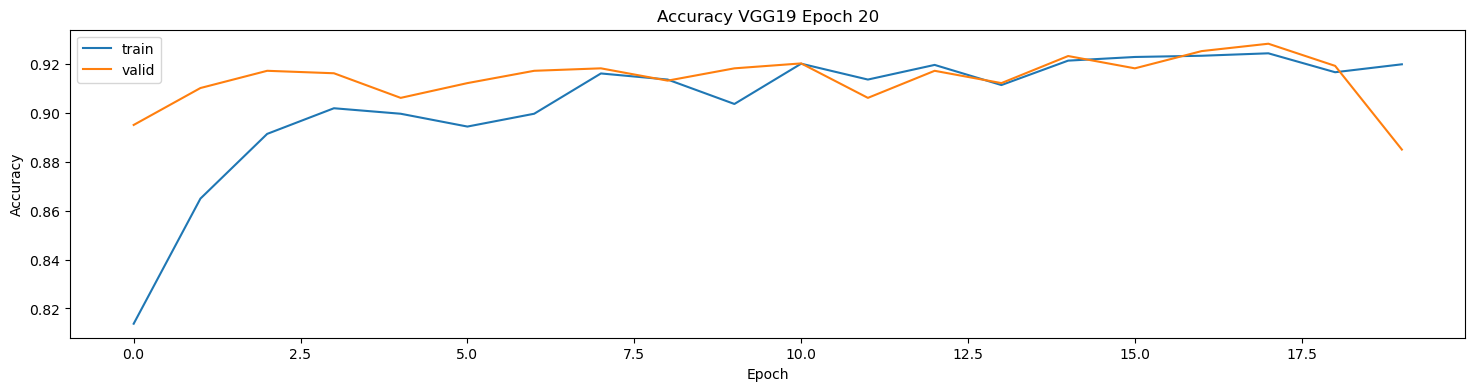

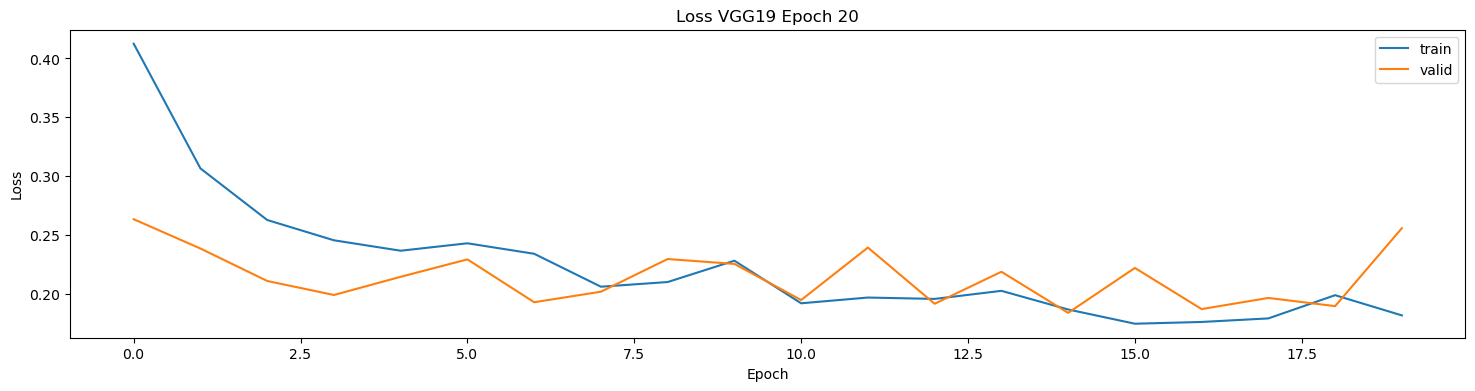

In [ ]:
plot_history(history_vgg19_ep20, 'VGG19 Epoch 20')

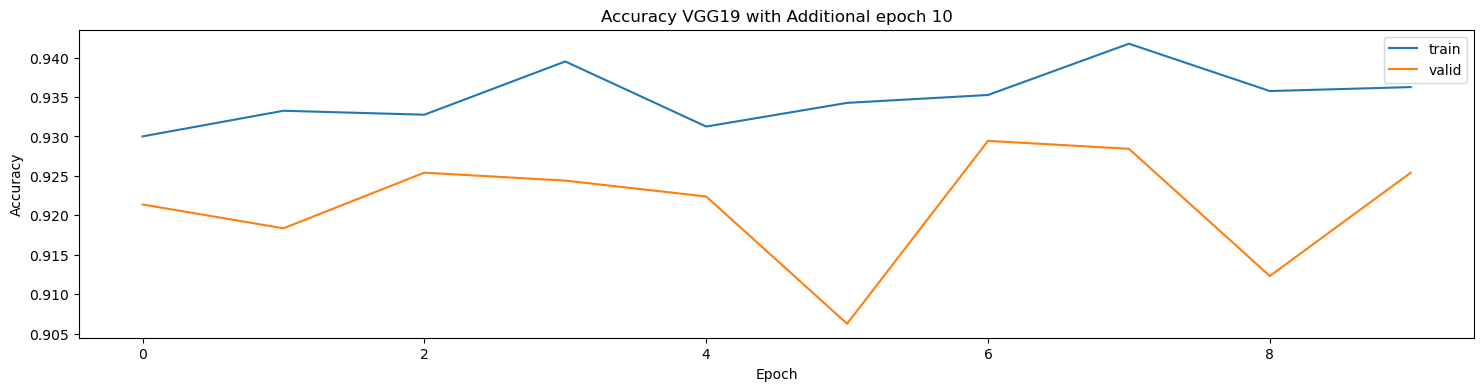

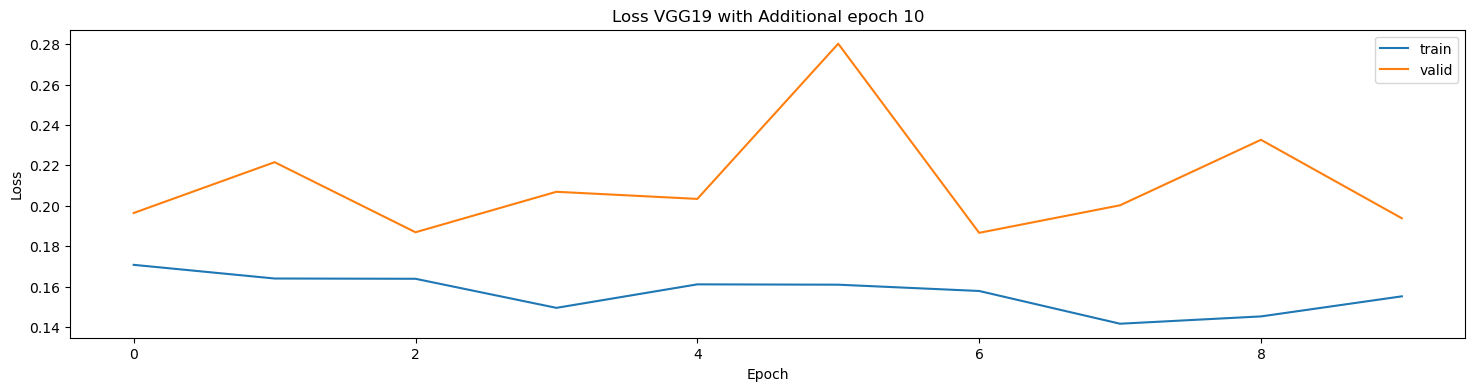

In [ ]:
plot_history(history_vgg19_ep30, 'VGG19 with Additional epoch 10')

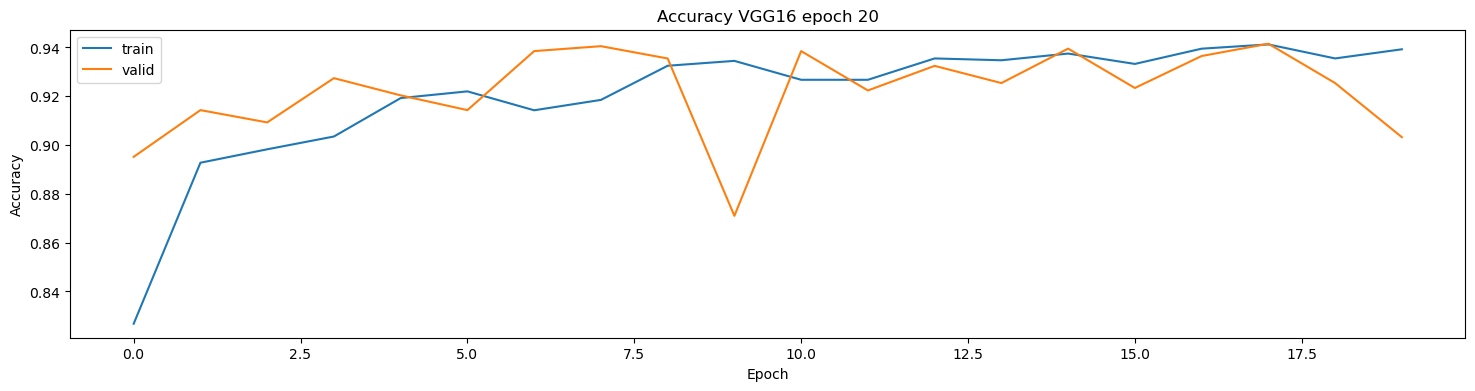

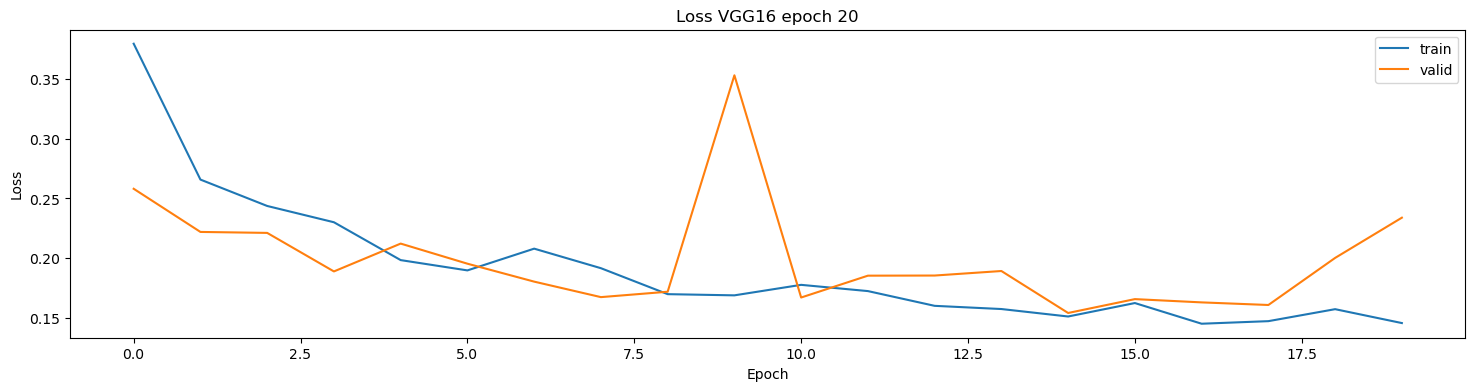

In [ ]:
plot_history(history_vgg16_ep20, 'VGG16 epoch 20')

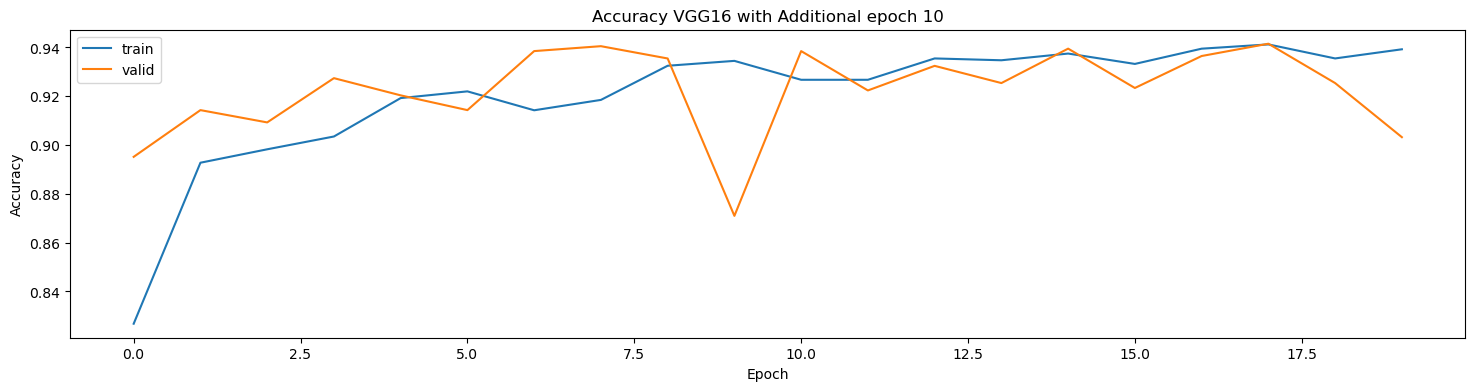

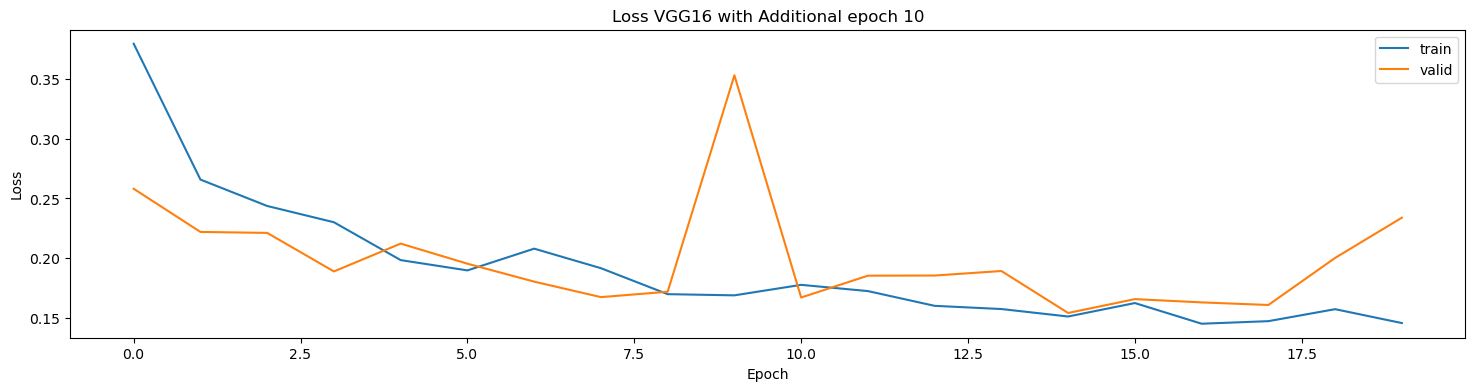

In [ ]:
plot_history(history_vgg16_ep20, 'VGG16 with Additional epoch 10')